# Simex NOVSL
This notebook runs `sumo_simulator_novsl` function which is modified to not use any VSL.

For running SUMO adjust the path in the `global_settings.py` file. The global_settings.py file also contains the parameters to be set for the simulation such as interval list. The following loop runs the selected sumo simulation for selected modifiers in the loop until it approximate every region or reaches the minimum step.
The sumo simulation function is defined in the `simulator.py` file. The function definitions for the simulator and modifier are defined in the `components.py` such as `components['sumo_simulator_novsl']`.

## Important settings
Adjust the sumo path:
```python
# SUMOvsl settings
sumovsls = {"model_path": "C:/Users/kusic/Desktop/SSF/SUMOVSL/SPSC_MD/model_MD/",
           "sumo_path": "C:/Program Files (x86)/Eclipse/Sumo/bin/sumo"} # sumo or sumo-gui
```

Setting the min/max domain interval and increment unit for the modifiers:
```python
# Modifier Domain Settings
mds = {"domain_min_interval": 2500,
       "domain_max_interval": 4000,
       "modifier_incremental_unit": 25, #increment
       "modifier_data_point": 100 # ID
       }
```
Setting the threshold for the validator:
```python
# Validator Function Settings
vfs = {'threshold_y_fitting': 15,
       'threshold_x_interval': 0.80,
       'degree': 2,
       'max_deg': 9,
       'early_stop': True,
       'improvement_threshold': 0.1,
       'penality_weight': 1,
       'x_labels': 'Traffic volume [veh/h]',  # Y axis label name validator graph
       'y_labels': 'TTS [veh$\cdot$h]',  # Y axis label name validator graph
       'title': f'Fitted Curve with unfit Intervals for {os.environ["INSTANCE_NAME"]}',  # Title for validator graph
       'figsize_x': 12,  # X size of the figure
       'figsize_y': 6,  # Y size of the figure
       'font_size': 12  # Font size in the figure
       }
```
Settings for the final plot with overall curves:
```python
# Overall plot settings
ops = {
    'x_labels': 'Traffic volume [veh/h]',
    'y_labels': 'TTS [veh$\cdot$h]',
    'title': f'Total fitted curves for {os.environ["INSTANCE_NAME"]} case',
    'figsize_x': 10,  # X size of the figure
    'figsize_y': 5,  # X size of the figure
    'linewidth': 3  # Linewidth for the functions
    }
```
At the top of the notebook set up the instance name which will be used in the global_settings file:
```python
# Set instance name 
os.environ['INSTANCE_NAME'] = 'VSL'
````
Settings for the filenames:
```python
fs = {
    "log_filename": f"LOG-{os.environ['INSTANCE_NAME']}",
    "csv_filename": f"simex_output-{os.environ['INSTANCE_NAME']}"
    }
```
**NOTE**: After running the main function one can run the next cell to save the logger object overall fitted functions.

In [1]:
# IMPORT LIBRARIES
import os
import numpy as np
# Set instance name 
os.environ['INSTANCE_NAME'] = 'NOVSL'

from global_settings import simexSettings, mds, timestamp

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# Create directory for the results
script_dir = os.path.abspath('')
results_dir = os.path.join(script_dir, f'{simexSettings["results_dir"]}')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

from components_configuration import components
from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

validator_controller_novsl = ValidatorController()
logger = Logger()
logger_main_arguments = {}
is_main_func = True
# Initialize interval list for the first iteration
intervals_list=[[mds['domain_min_interval'], mds['domain_max_interval']]]

# Timestamp for the validator pickle file
count = 0
filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

import time
before = time.time()

while is_main_func:
    
    # Calls Modifier Controller
    # NOTE: intervals_list type is set to np.int64 due to: https://github.com/numpy/numpy/issues/8433 on windows
    mod_outcome = ModifierController.control(intervals_list=intervals_list,selected_modifier=components['modifierA'], do_plot=simexSettings['do_plot'])
    mod_x_list = mod_outcome[0]
    checked_intervals = mod_outcome[1]
    print("MAIN mod outcome", mod_outcome)  

    
    # breaks loop if iterations end by granularity reached
    if not mod_x_list: # FALSE IF ['modifier_data_point'] < mdv['modifier_incremental_unit']:
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no generated points'
        logger_main_arguments['remaining_unfit_intervals'] = checked_intervals
        logger.log_main(logger_main_arguments)
        break
    
    # Calls Simulator
    mod_x,sim_y_list = SimulatorController.simulate_parallel(mod_x_list,selected_simulator=components['sumo_simulator_novsl'])
    print(f"MODX {mod_x} and sim_y_list {sim_y_list}")
    assert len(mod_x) == len(sim_y_list)

    print("MAIN modx", mod_x)  

    # Calls Validator controller
    intervals_list =  validator_controller_novsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[mds["domain_min_interval"], mds["domain_max_interval"]])
    print("MAIN interval list from VAL:", intervals_list)
    # Loop number (loop-1,loop2..etc)
    count +=1
    save_object(validator_controller_novsl,f"vc_{os.environ['INSTANCE_NAME']}_loop-{count}-{timestamp}.pkl")
    
    # Updates interval_list to new range output from validator controller
    # No more unfit intervals -> write MAIN log
    if not intervals_list:
        is_main_func = False
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no unfit intervals'
        logger.log_main(logger_main_arguments)

# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)

now = time.time()
print(f"Run time: {(now-before)/60}")

False


KeyError: 'SUMO'

In [2]:
import os
os.environ['INSTANCE_NAME'] = 'NOVSL'
# Save data for the last plot located in logger object
save_object(logger.all_fit_intervals_data,f"logger-{os.environ['INSTANCE_NAME']}-fitted_intervals-{filename1}.pkl")
# If not empty
if logger.remaining_unfit_intervals:
    save_object(logger.remaining_unfit_intervals,f"logger-{os.environ['INSTANCE_NAME']}-unfitted_intervals-{filename1}.pkl")
print(f"Logger object saved with timestamp {filename1}")

Logger object saved with timestamp 20240723-151000


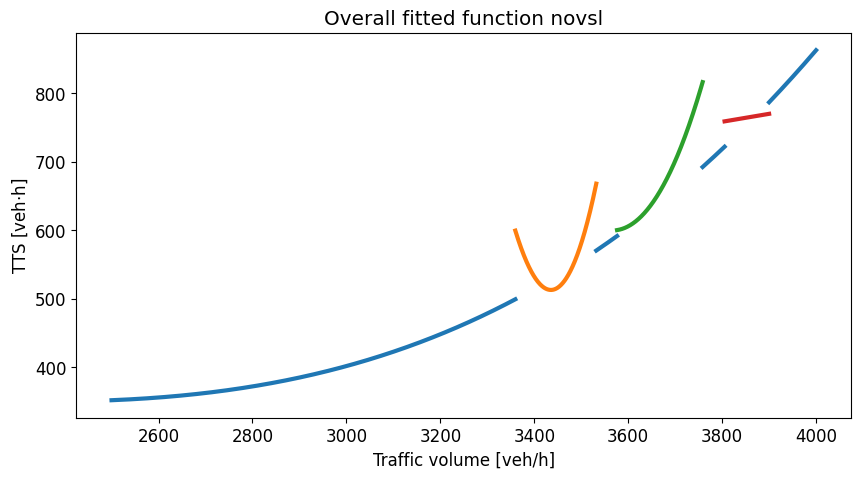

In [2]:
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from global_settings import lgs, mgs


all_fit_intervals_data = logger.all_fit_intervals_data
remaining_unfit_intervals = logger.remaining_unfit_intervals
_, ax = plt.subplots(figsize=(10, 5))

colors = {}
# Plot FI intervals with their fitting functions
for element in all_fit_intervals_data:
    interval = element['interval']
    fitting_function_str = element['fitting_function']

    # Convert the string into a function
    terms = re.findall(
        r'([+-]?\s*\d+\.?\d*(?:e[+-]?\d+)?)(x\^\d+)?', fitting_function_str.replace(' ', ''))
    coefficients = [0] * 10  # Initialize a list of 10 zeros
    for term in terms:
        coef = float(term[0])
        if term[1]:  # If there is an 'x' term
            exponent = int(term[1][2:])  # Get the exponent
            while len(coefficients) <= exponent:  # Expand the list if needed
                coefficients.append(0)
            # Assign the coefficient to the corresponding position in the list
            coefficients[exponent] = coef
        else:  # If there is no 'x' term, it's the constant term
            coefficients[0] = coef
    # Reverse the list to match the order expected by np.poly1d
    fitting_function = np.poly1d(coefficients[::-1])

    # Adjust the number of points as needed
    x = np.linspace(interval[0], interval[1], 400)
    y = fitting_function(x)
    if fitting_function_str in colors.keys():
        ax.plot(x, y, linewidth=3, label=f'Interval vsl: [{round(interval[0]), round(interval[1])}]',
            color=colors[fitting_function_str])
    else:
        ax.plot(x, y, linewidth=3, label=f'Interval vsl: [{round(interval[0]), round(interval[1])}]')
        color = ax.get_lines()[-1].get_color()
        colors[fitting_function_str] = color

for element in remaining_unfit_intervals:
    ax.axvspan(*element['interval'], color='gray',
               alpha=0.3, label='unfit Interval')
plt.title("Overall fitted function novsl")
plt.xlabel('Traffic volume [veh/h]')
plt.ylabel('TTS [veh$\cdot$h]')
plt.savefig(f"total_function-novsl.pdf", format='pdf')